In [152]:
import sys
sys.path.append("/Users/savard/PLUTO/pluto_playtime/plotting_analysis/")
sys.path.append("/Users/savard/PLUTO/")
import pyPLUTO as pypl
import pyPLUTO.pload as pp
import pandas as pd
from pyplutplot import *
wdir = '/pluto_playtime/data_storage/' #set up working directory where data is stored
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import time
import math

In [153]:
import multiprocessing as mp
from numba import jit
import numba as nb

choose which timestep to use

In [154]:
def tstep_to_days(t,dbl_step):
    """converts simulation steps into days.
    assumes a fixed simulation time unit writing a step every multiple of dbl_step
    """
    T_SIM_YEARS = 3.173e-02
    d = t*T_SIM_YEARS*365*dbl_step
    return d

def days_to_tstep(days, dbl_step):
    T_SIM_YEARS = 3.173e-02
    t = days/(T_SIM_YEARS*365*dbl_step)
    return t

def gamma_to_beta(gamma):
    beta = (1.-(gamma**-2))**0.5
    return beta

def beta_to_gamma(beta):
    gamma = 1./((1.-beta**2)**0.5)
    return gamma

def theta_from_beta(beta):
    theta = np.arccos(0.4/beta)*180/np.pi
    return theta

Load in data from current simulation at given timestep

In [155]:
##### ------- simulation setup--------- ##########
image_timestep = 287
dbl_step = 250

sim_name = 'gamm7_early'
rotate = False
angle_degrees = 30.0
save_or_load = 'save'
##### --------------------------------- ##########

data_dir = '/pluto_playtime/data_storage/'+sim_name+'/' #set up working directory where data is stored
fig_dir = '/Users/Shared/Data/savard/PLUTO/pluto_playtime/analysis_cirx1/'+sim_name+'/'


distance_in_pc = 9400

alpha= -0.507 #is this ok? already assumed for the luminosity conversion
kappa = 0.1 #fraction of pressure contribution to luminosity


P_sim = 1.503*10**(-4) #kg m^-1 s^2
L_sim = 3.000e+14 #m
nu_observe = (1.28* 1e9) #1.28 GHz (Bright2020)
eta=0.75

exponent = (3-alpha)/2
p = (4*exponent) - 5 #2.01
viewing_angle = (2*np.pi)/360 *angle_degrees

print("age in years: {:.0f}".format(tstep_to_days(image_timestep,dbl_step)/365.0))
D = load_data_obj(data_dir,image_timestep,data_type='flt')

age in years: 2277
data type: flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/rho.0287.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/vx1.0287.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/vx2.0287.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/vx3.0287.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/prs.0287.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/tr1.0287.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/tr2.0287.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/gamm7_early/tr3.0287.flt


plot the timestep to check its the right one

### Downsample in original grid

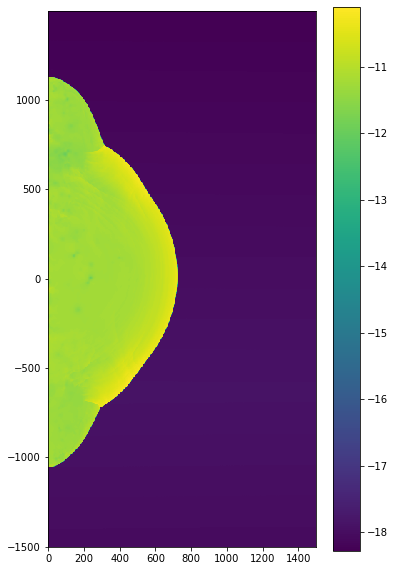

In [156]:
fig = plt.figure(figsize=[6,10])
#psuedo emissivity

sampling = 4

v = (((kappa*D.prs)**exponent))[::sampling,::sampling]
x1 = D.x1[::sampling]
x2 = D.x2[::sampling]
plt.pcolormesh(x1,x2,np.log10(v.T),shading='auto')
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [157]:
em = (((kappa*D.prs)**exponent)).T[::sampling,::sampling] #psuedo emissivity, 2D array 
ax1 = D.x1[::sampling]
ax2 = D.x2[::sampling]
print(np.shape(em))

(750, 375)


### Turn 2D cylindrical into 3D cylindrical, and boost emissivities

In [158]:
r = ax1 #r, 160 vals
z = ax2 #z, 1600 vals

NTHETA = 50
thetas = np.linspace(0,np.pi/2,NTHETA) #create some theta to wrap it around pi/2, arbitrary number of steps for now

#iteration vars
theta_len = len(thetas)
z_len = len(z)
r_len = len(r)


In [159]:
@jit
def los_angle(theta,viewing_angle,vx1,vx2,beta):
    denom = (vx1*np.sin(theta)*np.cos(-viewing_angle))-(vx2*np.sin(-viewing_angle))
    phi = np.arccos(denom/beta)
    return phi

@jit
def angle_to_boost(angle,beta):
    gamma = (1-(beta**2))**(-0.5)
    #change minus sign for approaching (-) or receding (+) jet
    delta = (gamma**(-1))*(1.0-beta*np.cos(angle))**(-1)
    return delta

@jit
def doppler_boost_lum(beta,viewing_angle,alpha,lum):
    delta = angle_to_boost(viewing_angle,beta)
    boosted_lum = lum*(delta**(2-alpha))
    return boosted_lum


In [160]:
#@jit(nb.types.Tuple((nb.float64[:,:],nb.float64[:,:],nb.float64[:,:],nb.float64[:,:]))(nb.float32[:,:],nb.float32[:,:],nb.float32[:,:],nb.float32[:,:],nb.float64[:],nb.float32[:,:],nb.float64[:],nb.float64),nopython=True)

@jit
def ordered_cylindrical_grid(Dvx1,Dvx2,z,r,values,thetas,viewing_angle,alpha):
    # creating long 2D arrays which correspond to each point in the frame -> ordered by constant z 
    theta_len = thetas.size
    height = z.size
    r_len = r.size
    width = r_len*theta_len
    

    rr = np.zeros((height,width))
    zz = np.zeros((height,width))
    tt = np.zeros((height,width))
    ll = np.zeros((height,width))
    beta_abs = np.sqrt(Dvx2**2 + Dvx1**2)
    for i in range(height):
        for j in range(r_len):
            #constant r iteration with all theta
            arr_z = np.repeat(z[i],theta_len)
            arr_r = np.repeat(r[j],theta_len)
            #doppler boost the emissivity with rotation of 30 deg and theta dependence
            phi_dopps = los_angle(thetas,viewing_angle,Dvx1[j][i],Dvx2[j][i],beta_abs[j][i])
            boosted_ems = doppler_boost_lum(beta_abs[j][i],phi_dopps,alpha,values[j][i])
            start_index = j*theta_len
            ll[i][start_index:start_index+theta_len] = boosted_ems
            rr[i][start_index:start_index+theta_len] = arr_r
            zz[i][start_index:start_index+theta_len] = arr_z
            tt[i][start_index:start_index+theta_len] = thetas
    
    return rr,zz,tt,ll

In [161]:
rr, zz, tt, ll = ordered_cylindrical_grid(D.vx1,D.vx2,z,r,em.T,thetas,viewing_angle,alpha)

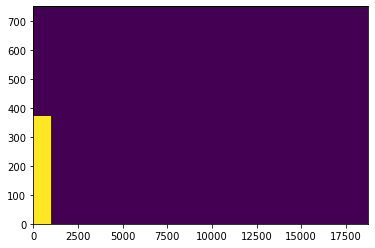

In [162]:
m = np.zeros((len(z),len(r)*theta_len))
for i in range(int(len(z)/2)):
    m[i][0:1000]=np.ones(1000)
plt.pcolormesh(m)

In [163]:
start = time.perf_counter()
rr, zz, tt, ll = ordered_cylindrical_grid(D.vx1,D.vx2,z,r,em.T,thetas,viewing_angle,alpha)
end = time.perf_counter()
print("Elapsed (with compilation) = {}s".format((end - start)))

start = time.perf_counter()
rr, zz, tt, ll = ordered_cylindrical_grid(D.vx1,D.vx2,z,r,em.T,thetas,viewing_angle,alpha)
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

Elapsed (with compilation) = 1.3218574170023203s
Elapsed (after compilation) = 1.3136019579833373s


In [164]:
# creating long 2D arrays which correspond to each point in the frame -> ordered by constant z 
rr = []
zz = []
tt = []
ll = []
#r = ax1
#z = ax2

values = em.T

beta_abs = np.sqrt(D.vx2**2 + D.vx1**2)[::sampling,::sampling]
vx1 = D.vx1[::sampling,::sampling]
vx2 = D.vx2[::sampling,::sampling]

for i in range(z_len):
    #constant z iteration
    z_ordered = []
    r_ordered = []
    l_ordered = []
    theta_ordered = []
    for j in range(r_len):
        #constant r iteration with all theta
        arr_z = np.repeat(z[i],theta_len).tolist() #repeated z
        arr_r = np.repeat(r[j],theta_len).tolist() #repeated r 
        #doppler boost the emissivity with rotation of 30 deg and theta dependence
        phi_dopps = los_angle(thetas,viewing_angle,vx1[j][i],vx2[j][i],beta_abs[j][i])
        boosted_ems = doppler_boost_lum(beta_abs[j][i],phi_dopps,alpha,values[j][i])
        l_ordered.append(boosted_ems)
        r_ordered.append(arr_r) # r at i (const in j loop)
        z_ordered.append(arr_z) # z at j (iterating through const r)
        theta_ordered.append(thetas) # for all theta
    rr.append(np.asarray(r_ordered).flatten())
    zz.append(np.asarray(z_ordered).flatten())
    ll.append(np.asarray(l_ordered).flatten())
    tt.append(np.asarray(theta_ordered).flatten())

In [165]:
mm = np.zeros((750, 18750))
np.shape(mm)

(750, 18750)

#### convert from cylindrical to carrotesian 🥕

In [166]:
@jit
def cyl_to_cart(r,z,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = z
    return x, y, z

In [167]:
#convert to cartesian:
x_cart, y_cart, z_cart = cyl_to_cart(rr, zz, tt)

<ipython-input-166-8b0477d6c765>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cyl_to_cart" failed type inference due to: No implementation of function Function(<ufunc 'cos'>) found for signature:
 
 >>> cos(reflected list(array(float64, 1d, C))<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'Numpy_rules_ufunc.generic': File: numba/core/typing/npydecl.py: Line 96.
    With argument(s): '(reflected list(array(float64, 1d, C))<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: can't resolve ufunc cos for types (reflected list(array(float64, 1d, C))<iv=None>,)
  raised from /Users/savard/opt/anaconda3/envs/lower_python_env/lib/python3.6/site-packages/numba/core/typing/npydecl.py:102

During: resolving callee type: Function(<ufunc 'cos'>)
During: typing of call at <ipython-input-166-8b0477d6c765> (3)


File "<ipython-input-166-8b047

In [168]:
z_ordered = []
num_z = len(ax2)
num_xtheta = len(ax1)*len(thetas)

for i in range(num_z):
    z_ = z_cart[(0+(num_xtheta*i)):(0+(num_xtheta*(i+1)))]
    z_ordered.append(z_)



Text(0.5, 1.0, 'original cylindrical grid')

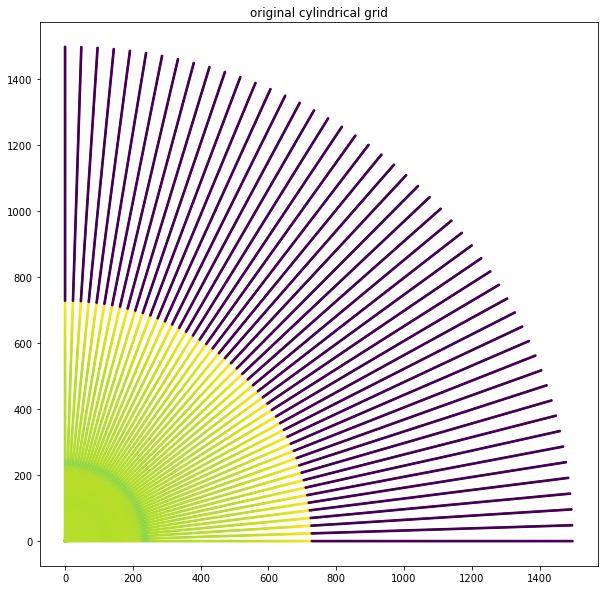

In [169]:
fig = plt.figure(figsize=(10,10))
slice = int(len(z_cart)/2)

plt.scatter(x_cart[slice],y_cart[slice],s=3,c=np.log10(ll[slice]))
plt.title('original cylindrical grid')

### Rotate the cylindrical grid points to be 30 degrees inclined to the LOS

In [170]:
@jit
def rotate_cartesian(x,y,z,theta):
    yp = (y*np.cos(theta))-(np.array(z)*np.sin(theta))
    zp = (y*np.sin(theta))+(np.array(z)*np.cos(theta))
    xp = x
    return xp, yp, zp

In [171]:
def dontrotate(x,y,z):
    return x,y,z

In [172]:
if rotate:
    x_cart_irr, y_cart_irr , z_cart_irr = rotate_cartesian(x_cart,y_cart,z_cart,-viewing_angle)
else:
    x_cart_irr, y_cart_irr , z_cart_irr = dontrotate(x_cart , y_cart, z_cart)

No handles with labels found to put in legend.


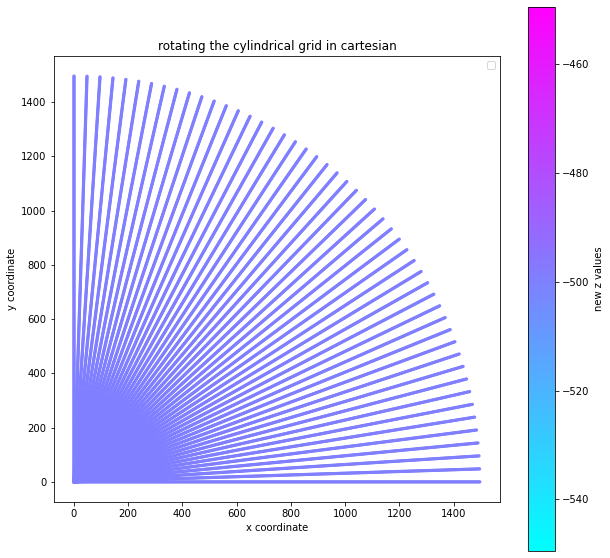

In [173]:
height = int(len(z_cart)/3)

fig = plt.figure(figsize = (10,10))
#og = plt.scatter(x_cart[height],y_cart[height],s=5,c='black',label='original cartesian points') #all z values are the same for this slice 
rot = plt.scatter(x_cart_irr[height],y_cart_irr[height],s=5,c=z_cart_irr[height],cmap='cool')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
#plt.colorbar(og)
cbar = plt.colorbar(rot)
cbar.set_label('new z values')
plt.legend()
plt.title('rotating the cylindrical grid in cartesian')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [174]:
plt.close()
del fig

### Create a new 2D grid to interpolate onto

In [187]:
@jit
def new_cartesian_grid(x_new,y_new, z_new,r):
    #create new grid 2D to interpolate on
    cell_size = r[1]-r[0] #used to be grid size
    y = np.max(x_new)
    xlen = int((np.max(x_new)-np.min(x_new))/cell_size)
    ylen = int((np.max(y_new)-np.min(y_new))/cell_size)
    zlen = int((np.max(z_new)-np.min(z_new))/cell_size)
    #the spacing of the goal grid is the same as the original 2D cylindrical grid
    x_ar = np.linspace(np.min(x_new),np.max(x_new),xlen)
    y_ar = np.linspace(np.min(y_new),np.max(y_new),ylen)
    z_ar = np.linspace(np.min(z_new),np.max(z_new),zlen)
    return x_ar, y_ar, z_ar

In [190]:
x_ar_newgrid, y_ar_newgrid, z_ar_newgrid = new_cartesian_grid(np.array(x_cart_irr),np.array(y_cart_irr),np.array(z_cart_irr),r)

In [123]:
#create new grid 2D to interpolate on
cell_size = r[1]-r[0] #used to be grid size
xlen = int((np.max(x_cart_irr)-np.min(x_cart_irr))/cell_size)
ylen = int((np.max(y_cart_irr)-np.min(y_cart_irr))/cell_size)
zlen = int((np.max(z_cart_irr)-np.min(z_cart_irr))/cell_size)
#the spacing of the goal grid is the same as the original 2D cylindrical grid
x_ar_newgrid = np.linspace(np.min(x_cart_irr),np.max(x_cart_irr),xlen+1)
y_ar_newgrid = np.linspace(np.min(y_cart_irr),np.max(y_cart_irr),ylen+1)
z_ar_newgrid = np.linspace(np.min(z_cart_irr),np.max(z_cart_irr),zlen+1)
grid_x, grid_y = np.meshgrid(x_ar_newgrid,y_ar_newgrid)

print("Expanded box to account for tilting:")
print("x size: "+str(ax1.size)+" -> "+str(x_ar_newgrid.size))
print("y size: "+str(ax1.size)+" -> "+str(y_ar_newgrid.size))
print("z size: "+str(ax2.size)+" -> "+str(z_ar_newgrid.size))

Expanded box to account for tilting:
x size: 375 -> 375
y size: 375 -> 375
z size: 750 -> 750


Text(0.5, 1.0, 'cartesian grid to interpolate on')

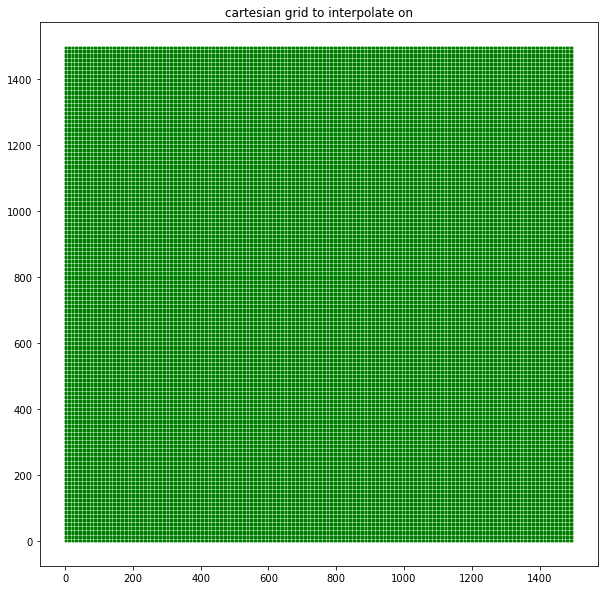

In [124]:
fig = plt.figure(figsize=(10,10))
plt.plot(grid_x,grid_y,'o',markersize=0.8,color='green')
plt.title('cartesian grid to interpolate on')

In [125]:
plt.close()
del fig

# Interpolating onto Cartesian grid

In [126]:
def loader_bar(i,range,modulo): #just for output purposes
    perc = int((i/range)*100)
    prev_perc = int(((i-1)/range)*100)
    if i==0:
        s = str(0)+"%"
        print(s,end="...",flush=True)
    if perc%modulo==0 and perc!=prev_perc:
        s = str(perc)+"%"
        print(s,end="...",flush=True)
        prev=perc+modulo

In [127]:

def interpolate_onerow_flat(i,x_new,y_new,grid_x,grid_y):
    x_arr = x_new[i].flatten() #160x130 points -> 20800
    y_arr = y_new[i].flatten()
    points = (x_arr,y_arr)
    values = np.array(ll)[i].flatten()
    interp_grid = (grid_x,grid_y)
    interp = griddata(points,values,interp_grid,method='linear')

In [128]:
#x_flat = x_new[i].flatten() #160x130 points -> 20800
#y_flat = y_new[i].flatten()
#ll_flat = np.array(ll)[i].flatten()
def interpolate_onerow_flat(args):
    x_flat,y_flat,ll_flat,grid_x,grid_y = args
    points = (x_flat,y_flat)
    interp_grid = (grid_x,grid_y)
    interp = griddata(points,ll_flat,interp_grid,method='linear')
    return interp

In [129]:
items = range(len(z_cart_irr))
#need to make grid_x and grid_y accessible everywhere somehow 
with mp.Pool(6) as pool:
    iter_num = range(len(z_cart_irr))
    args = [(x_cart_irr[i].flatten(),y_cart_irr[i].flatten(),ll[i].flatten(),grid_x,grid_y) for i in iter_num]
    result = pool.map(interpolate_onerow_flat,args)

In [130]:
interp_clean = np.nan_to_num(result)

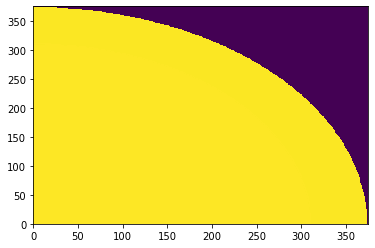

In [131]:
plt.pcolormesh(interp_clean[0])

In [132]:
save_list(np.asarray(interp_clean),fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep))

In [ ]:
def interpolate_onerow_flat(args):
    x_flat,y_flat,ll_flat,grid_x,grid_y = args
    points = (x_flat,y_flat)
    interp_grid = (grid_x,grid_y)
    interp = griddata(points,ll_flat,interp_grid,method='linear')
    return interp

In [193]:
start = 10
end = 17
for t in range(start,end+1):
    print(t) 

10
11
12
13
14
15
16
17


In [30]:
def interpolate_flat_mpi(x_ar,y_ar,x_new,y_new,z_new,ll,cell_size,fig_dir,sim_name,image_timestep):
    if save_or_load=='save':
        grid_x, grid_y = np.meshgrid(x_ar,y_ar)
        iter_num = len(z_new)
        with mp.Pool(6) as pool:
            args = [(x_new[i].flatten(),y_new[i].flatten(),ll[i].flatten(),grid_x,grid_y) for i in iter_num]
            interps = pool.map(interpolate_onerow_flat,args)
        
        interp_clean = np.nan_to_num(interps) #remove all nans and turn them into zeros for the sake of integration 
        save_list(np.asarray(interp_clean),fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep))
        
        integrated_frames = []
        pixel_vol = (cell_size)**3 #multiply by the volume of each pixel when integrating
        for frame in interp_clean:
            integrated_frame = np.sum(frame,axis=0)*pixel_vol*2
            integrated_frames.append(integrated_frame)
        save_list(np.asarray(integrated_frames),fig_dir,'integrated_frame_'+sim_name+'_'+str(image_timestep))
    elif save_or_load=='load':
        print("loading")
        interp_clean = load_list(fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep))
        integrated_frames = load_list(fig_dir,'integrated_frame_'+sim_name+'_'+str(image_timestep))
    return interp_clean, integrated_frame

In [ ]:
def interpolate_flat(x_ar,y_ar,x_new,y_new,z_new,ll,cell_size,fig_dir,sim_name,image_timestep):
    if save_or_load=='save':
        grid_x, grid_y = np.meshgrid(x_ar,y_ar)
        interps = []
        iter_num = len(z_new)
        for i in range(iter_num):
            loader_bar(i,iter_num,5)
            interp = interpolate_onerow_flat(x_new,y_new,grid_x,grid_y)
            interps.append(interp)
        
        interp_clean = np.nan_to_num(interps) #remove all nans and turn them into zeros for the sake of integration 
        save_list(np.asarray(interp_clean),fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep))
        
        integrated_frames = []
        pixel_vol = (cell_size)**3 #multiply by the volume of each pixel when integrating
        for frame in interp_clean:
            integrated_frame = np.sum(frame,axis=0)*pixel_vol*2
            integrated_frames.append(integrated_frame)
        save_list(np.asarray(integrated_frames),fig_dir,'integrated_frame_'+sim_name+'_'+str(image_timestep))
    elif save_or_load=='load':
        print("loading")
        interp_clean = load_list(fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep))
        integrated_frames = load_list(fig_dir,'integrated_frame_'+sim_name+'_'+str(image_timestep))
    return interp_clean, integrated_frame

In [31]:
def interpolate_entirity_rotated(x_ar_interp,y_ar_interp,z_ar_interp,x_ar_points,y_ar_points,z_ar_points,vals):
    print('making gridmesh...')
    grid_x, grid_y, grid_z = np.meshgrid(x_ar_interp,y_ar_interp,z_ar_interp,indexing='ij')
    print('made gridmesh...')
    interp_grid = (grid_x,grid_y,grid_z)
    x_new_flat= x_ar_points.flatten() 
    y_new_flat = y_ar_points.flatten()
    z_new_flat = z_ar_points.flatten()
    points = (x_new_flat,y_new_flat, z_new_flat)
    values = np.array(vals).flatten()
    print('interpolating...')
    interp = griddata(points,values,interp_grid,method='linear')
    interp_clean = np.nan_to_num(interp) #remove all nans and turn them into zeros for the sake of integration 
    print('saving...')
    save_list(np.asarray(interp_clean),fig_dir,'interpolated_frame_'+sim_name)
    return interp_clean

In [ ]:
def chunk_irregular(x_cart_irr,y_cart_irr,z_cart_irr,ll,minrange,maxrange):
    """chunks irregular cartesian points into only points within a LEQ z range 

    Args:
        x_new (_type_): _description_
        y_new (_type_): _description_
        z_new (_type_): _description_
        minrange (_type_): _description_
        maxrange (_type_): _description_

    Returns:
        _type_: _description_
    """
    x_include = []
    y_include = []
    z_include = []
    values_include = []
    for i_row, zrow in enumerate(z_cart_irr):
        for i_element, z  in enumerate(zrow):
            if minrange<=z<=maxrange:
                z_include.append(z)
                x_include.append(x_cart_irr[i_row][i_element])
                y_include.append(y_cart_irr[i_row][i_element])
                values_include.append(np.array(ll[i_row][i_element]*1e10))

    return x_include, y_include, z_include, values_include


In [ ]:
def dechunk(chungus_array):
    interp_chunk_whole = chungus_array[0]
    for arr in chungus_array[1:]:
        interp_chunk_whole = np.concatenate((interp_chunk_whole,arr),axis=2)
    print("chunked array shape: "+str(np.shape(interp_chunk_whole)))
    interp_clean = np.nan_to_num(interp_chunk_whole)
    return interp_clean


In [32]:
def interpolate_chunked_rotated(chunksize,x_ar,y_ar,z_ar,x_new,y_new,z_new,ll,cell_size,fig_dir,sim_name,image_timestep):
    dechunked = False
    #define min and max from chunk size : chunks are number of rows!!!! ie. z[0]->z[10]
    interps = []
    numchunks = math.ceil(len(z_ar)/chunksize)
    z_convert = np.max(z_new)/len(z_ar)
    buffer = 1*z_convert
    bottom_lim = 0 #row num
    top_lim = chunksize-1 #row num
    for chunkindex in range(numchunks):
        print("working on chunk {:f} to {:f} ({:f}:{:.0f}%)".format(bottom_lim,top_lim,chunkindex,100*top_lim/len(z_ar)))
        #find irregular points that lie within chunk
        bottom_lim_in_z = (bottom_lim*z_convert)-buffer #convert row chunks to actual z values
        top_lim_in_z = (top_lim*z_convert)+buffer #convert row chunks to actual z values
        xchunked, ychunked, zchunked, valueschunked = chunk_irregular(x_new,y_new,z_new,ll,bottom_lim_in_z,top_lim_in_z)
        print("interpolating over z = {:f} to {:f})".format(bottom_lim_in_z,top_lim_in_z))
        #create grid to interpolate onto, chunked
        if top_lim>=len(z_ar):
            top_lim = len(z_ar)-1
            print('last chunk: {:f}-{:f}'.format(bottom_lim,top_lim))
            grid_x, grid_y, grid_z = np.meshgrid(x_ar,y_ar,z_ar[bottom_lim:top_lim+1])
            #now perform interpolation 
            points = (xchunked,ychunked,zchunked) #irregular points to interpolate onto grid
            interp_grid = (grid_x,grid_y,grid_z)
            print("interping...")
            start = time.time()
            interp = griddata(points,valueschunked,interp_grid,method='linear')
            end = time.time()
            print("time to interp: "+str(end - start))
            interp_clean = dechunk(interps) #first dechunk the whole thing 
            interp_clean = np.concatenate((interp_clean,np.nan_to_num(interp)),axis=2)
            dechunked = True
            print("dechunking mini chunk")
            save_list(np.asarray(interp_clean),fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep)+'_chunked')
            break
        if top_lim-bottom_lim<1:
            print('wierd uneven chunk: {:f}-{:f}'.format(bottom_lim,top_lim))
            break
        else:
            grid_x, grid_y, grid_z = np.meshgrid(x_ar,y_ar,z_ar[bottom_lim:top_lim+1])
            #now perform interpolation 
            points = (xchunked,ychunked,zchunked) #irregular points to interpolate onto grid
            interp_grid = (grid_x,grid_y,grid_z)
            print("interping...")
            start = time.time()
            interp = griddata(points,valueschunked,interp_grid,method='linear')
            end = time.time()
            interps.append(interp)
            print("time to interp: "+str(end - start))
            save_list(np.asarray(interps),fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep)+'_chunked_temp')
            bottom_lim = bottom_lim+chunksize
            top_lim = top_lim+chunksize
    if not dechunked:
        print("dechunking default")
        interp_clean = dechunk(interps)
        start = time.time()
        save_list(np.asarray(interp_clean),fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep)+'_chunked')
    return interp_clean


In [53]:
def integrate_interped(interp_arr,cell_size,ax=0):
    integrated_frames = []
    pixel_vol = (cell_size)**3 #multiply by the volume of each pixel when integrating
    for frame in interp_arr.T:
        integrated_frame = np.sum(frame,axis=ax)*pixel_vol*2
        integrated_frames.append(integrated_frame)
    save_list(np.asarray(integrated_frames),fig_dir,'integrated_frame_'+sim_name+'_'+str(image_timestep)+'_chunked')
    return np.array(integrated_frames)

#### perform flat interpolation:

In [ ]:
if not rotate and save_or_load=='save':
    print('interpolating')
    interp_clean, integrated_frames = interpolate_flat(x_ar_newgrid,y_ar_newgrid,x_cart_irr,y_cart_irr,z_cart_irr,ll,cell_size,fig_dir,sim_name,image_timestep)

0%...5%...10%...15%...20%...25%...30%...35%...40%...45%...50%...55%...60%...65%...70%...75%...80%...85%...90%...95%...

In [ ]:
run_all = True

if run_all:
    tsteps = 500
    for i in range(tsteps):
        interp_clean, integrated_frames = interpolate_flat(x_ar_newgrid,y_ar_newgrid,x_cart_irr,y_cart_irr,z_cart_irr,ll,cell_size,fig_dir,sim_name,image_timestep)

#### perform chunked rotated interpolation:

In [54]:
if rotate and save_or_load=='save':
    print('interpolating')
    interp_clean = interpolate_chunked_rotated(20,x_ar_newgrid,y_ar_newgrid,z_ar_newgrid,x_cart_irr,y_cart_irr,z_cart_irr,ll,cell_size,fig_dir,sim_name,image_timestep)
    integrated_frames = integrate_interped(interp_clean,cell_size,ax=0)

#### load flat interpolation

In [55]:
if not rotate and save_or_load=='load':
    print('loading')
    interp_clean = load_list(fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep)+'_flat')
    integrated_frames = integrate_interped(interp_clean,cell_size,ax=0)

loading


#### load chunked rotated interpolation

In [56]:
if rotate and save_or_load=='load':
    print('loading')
    interp_clean = load_list(fig_dir,'interpolated_frame_'+sim_name+'_'+str(image_timestep)+'_chunked')
    integrated_frames = integrate_interped(interp_clean,cell_size,ax=0)

### Integrate 


Plot slice on interped

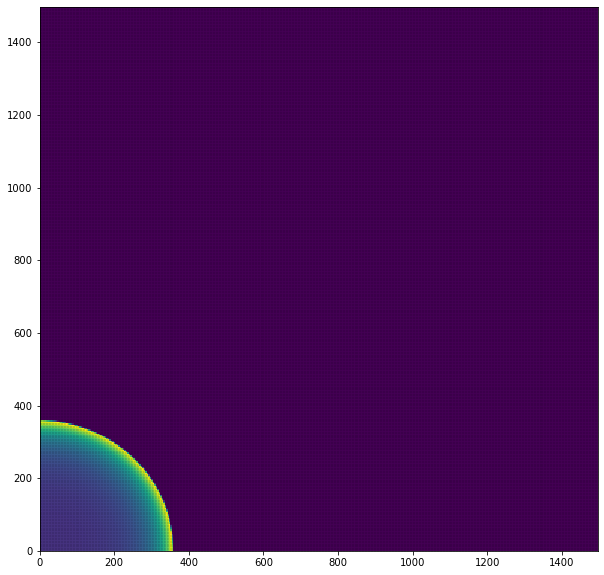

In [57]:
slice_index = 300
plt.figure(figsize=(10,10))
plt.pcolormesh(grid_x,grid_y,interp_clean[slice_index]*1e8,shading='flat')
plt.scatter(grid_x,grid_y,s=0.001,color='black')

In [58]:
np.shape(np.array(integrated_frames).T)

(750, 374)

Plot integrated

Lots on NANs in the data are there because of extremely small values of emissivity due to the tracer, they can be essentailly replaced with zeroes. 

/Users/savard/opt/anaconda3/envs/lower_python_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """
/Users/savard/opt/anaconda3/envs/lower_python_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


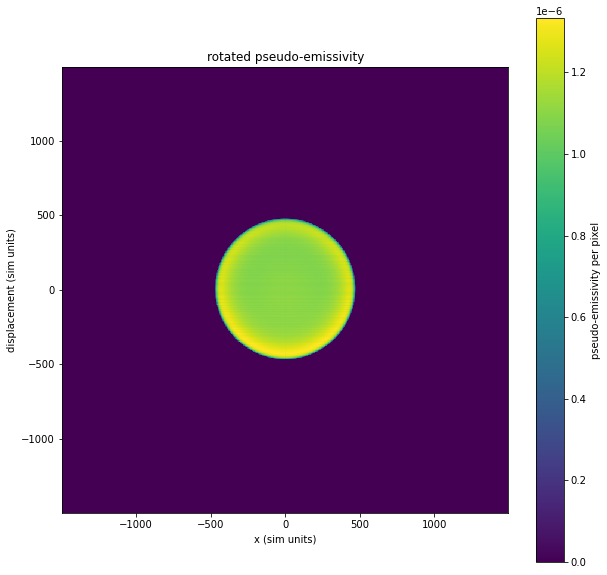

In [60]:
fsize=(10,10)

scale = len(ax2)/(len(ax1)*2)
plt.figure(figsize=fsize)
plt.pcolormesh(ax1,ax2,integrated_frames.T,shading='auto')
plt.pcolormesh(-ax1,ax2,integrated_frames.T,shading='auto')
cbar = plt.colorbar()

plt.title('rotated pseudo-emissivity')
plt.xlabel('x (sim units)')
plt.ylabel('displacement (sim units)')
cbar.set_label('pseudo-emissivity per pixel')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')


save = True

#name = 'rotated_frame_'+system_name+'_'+str(image_timestep)
#save_fig(results_folder,name,overwrite=save)

### Convert to Janskys! 

Specify simulation units and desired observational frequency, also departure from equipartition

In [ ]:
from pluto_luminosity_conversion import *

lum_real_unit = lum_unit_si(eta=0.75,P=P_sim,L=L_sim,nu=nu_observe, q=p) #W Hz^-1 sr^-1

In [ ]:
lum_sim = np.asarray(integrated_frames)
lum_true = lum_sim*lum_real_unit # W Hz^-1 sr^-1
lum_jansky = lum_true*(10**26)*np.pi*4 # 10^26 W Hz^-1  -> 10^-26 W m^-2 Hz^-1 = 1 jansky 

distance = distance_in_pc*3.086*(10**16) # convert parsec to m 

lum_jansky_far = np.asarray(lum_jansky / (4*np.pi*(distance**2)),dtype='float64')
boosted_lum = lum_jansky_far
save_list(boosted_lum,results_folder,'pixel_lum_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/(1e9))+str('GHz'))


Total integrated luminosity:

~85% resolved out flux density at 1.7mJy from observations at zeroth timestep 

In [ ]:
frame_flux = np.sum((boosted_lum*10**3))*2
print('total luminosity in frame in mJy: '+str(frame_flux))

total luminosity in frame in mJy: 2.08298005457993


In [ ]:
dtype='flt'

def image_to_lum(D,viewing_angle,alpha,kappa,boost=True):
    """calculates psudo emissivity of a simulation frame, and applies doppler boosting (if boost=True).
    the emissivity is then rotated and integrated to get a total emissivity of a frame in 3D.
    return a value of total emission in frame. 
    """
    emis = D.tr1*((kappa*(D.prs))**exponent)
    beta = D.vx2
    if boost:
        boosted_lum = doppler_boost_lum(beta,viewing_angle,alpha,emis)
    else:
        boosted_lum = emis
    grid_area = (D.x1[4]-D.x1[3])*(D.x2[4]-D.x2[3])
    rad , z = np.meshgrid(D.x1,D.x2) #format radius matrix to quickly multiply
    lum = boosted_lum*2*np.pi*rad.T*(grid_area) #rotate and integrate luminosity in cylindrical coords
    return lum

def total_lums(data_dir,viewing_angle,alpha,kappa,boost=True,first=False):
    """for each frame of a simulation, calculate the total emissivity per frame (doppler boosted
    if boost=True)
    """
    if first:
        max_step = 1
    else:
        max_step = get_max_step(data_dir)
    total_lums = []
    for i in range(max_step+1):
        D = load_data_obj(data_dir,i,data_type=dtype)
        lum = image_to_lum(D,viewing_angle,alpha,kappa,boost)
        total_lums.append(np.sum(lum))
    return total_lums

def lum_sim_to_jansky(lum,distance_in_pc):
    """converts from emissivity to janskys given some constant simulation units
    """
    P_SIM = 1.503*10**(-4) #in kg m^-1 s^2
    L_SIM = 1*10**13 #in meters
    NU_OBS = (1.28 * 1e9) #1.28 GHz (Bright2020)
    ETA = 0.75 #equipartition
    distance = distance_in_pc*3.086*(10**16) # convert parsec to m 
    print(distance_in_pc)

    lum_real_unit = lum_unit_si(eta=ETA,P=P_SIM,L=L_SIM,nu=NU_OBS,q=p) #W Hz^-1 sr^-1
    lum_true = np.asarray(lum)*lum_real_unit # W Hz^-1 sr^-1
    lum_jansky = lum_true*(10**26)*np.pi*4 # 10^-26 W Hz^-1, get rid of sr^-1 -> 10^-26 W m^-2 Hz^-1 = 1 jansky 
    lum_jansky_far = np.asarray(lum_jansky / (4*np.pi*(distance**2)),dtype='float64') #10^-26 W Hz^-1 m^-2
    return lum_jansky_far

lum1 = total_lums(data_dir,viewing_angle,alpha,kappa,boost=True,first=True)
print(lum1)
lum_jansky1 = lum_sim_to_jansky(lum1,distance_in_pc) #convert to janskys 

print("Initial lum: "+str(lum_jansky1[0]*10**3)+" mJy")

data type: flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2/rho.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2/vx1.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2/vx2.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2/vx3.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2/prs.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2/tr1.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2/tr2.0000.flt
data type: flt
Reading multiple variable

Plot luminosity in mJy:

In [ ]:
def m_to_arcseconds(m):
    acs = (m*100)/(1.496*10**(13))*(1/distance_in_pc)
    return acs

saving new figure!!


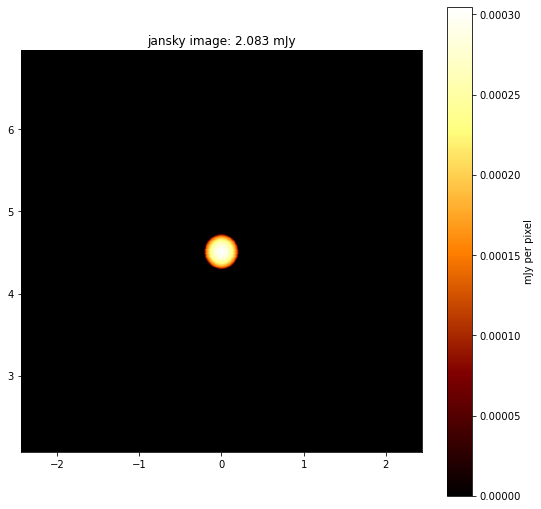

In [ ]:

x = m_to_arcseconds(ax1*L_sim)
y = m_to_arcseconds(ax2*L_sim)

scale = len(ax2)/(len(ax1)*2)
plt.figure(figsize=[9*scale,9])
plt.pcolormesh(x,y,(boosted_lum*10**3),cmap='afmhot',shading='auto')
plt.pcolormesh(-x,y,(boosted_lum*10**3),cmap='afmhot',shading='auto')
cbar = plt.colorbar()
cbar.set_label('mJy per pixel')

plt.title('jansky image: {:.3f} mJy'.format(frame_flux))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
save = True

name = 'radio_frame_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/(1e9))+str('GHz')
save_fig(results_folder,name,overwrite=save)

In [ ]:
np.shape((boosted_lum*10**3))

(1300, 650)

In [ ]:
np.shape(y)

(1300,)

## EZ-BLOB oven

In [ ]:
from astropy.io import fits

In [ ]:
ez_filename = 'pixel_lum_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/1e9)+'GHz'
image_array = load_list(results_folder,ez_filename)
image_array_flip = np.concatenate((np.flip(image_array,axis=1),np.array(image_array)),axis=1)

In [ ]:
#put this into wsclean command

np.shape(image_array_flip)

(1300, 1300)

In [ ]:
#if it needs reshaping for wsclean (odd numbers)

def adjust(image_array,axis='row'): #adds on an extra row
    if axis=='row':
        z = [0]*(len(image_array.T))
        new_image = np.row_stack([z,image_array])
    elif axis=='column':
        z = [0]*(len(image_array))
        new_image = np.column_stack([z,image_array])
    return new_image

#if its higher resolution on one axis (to make pixels square)
def deres_array(image_array,res,axis='row'): #remove every x=res rows from array
    new_lum_array = []
    if axis=='row':
        for index, row in enumerate(image_array):
            if index%res==1:
                new_lum_array.append(row)
    elif axis=='column':
        for index, column in enumerate(image_array.T):
            if index%res==1:
                new_lum_array.append(column)

    return new_lum_array

In [ ]:
def deres_array_check(image):
    #check if needs a deres
    column_resolution = image[1][5]-image[1][4]
    row_resolution = image[5][1]-image[4][1]
    if row_resolution==column_resolution:
        print('square elements, no need to de-res')
        print('Shape: '+str(np.shape(image)))
    else:
        if row_resolution>column_resolution:
            print('deres row')
            resolution_difference = row_resolution/column_resolution
            image = np.array(deres_array(image,resolution_difference),axis='row')
            print('New shape: '+str(np.shape(image)))
        else:
            print('deres column')
            resolution_difference = column_resolution/row_resolution
            image = np.array(deres_array(image,resolution_difference),axis='column')
            print('New shape: '+str(np.shape(image)))
    return image

In [ ]:
def even_shape_check(image):
    row_len = len(image[0])
    column_len = len(image.T[0])
    even = True
    print(row_len)
    print(column_len)
    print(row_len%2)
    print(column_len%2)
    if row_len%2==1:
        even=False
        print('adding another column')
        image = adjust(image,axis='column')
    if column_len%2==1:
        even=False
        print('adding another row')
        image = adjust(image,axis='row') 
    if even:
        print("image has even sides, no need to adjust")
    return image

In [ ]:
print(np.shape(image_array_flip))
#check if needs a deres
image_array_flip = deres_array_check(image_array_flip)

#check if the shape is even
image_array_flip = even_shape_check(image_array_flip)

print(np.shape(image_array_flip))

(1300, 1300)
square elements, no need to de-res
Shape: (1300, 1300)
1300
1300
0
0
image has even sides, no need to adjust
(1300, 1300)


In [ ]:
hdu = fits.PrimaryHDU(image_array_flip)
fits_name = 'ffile_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/1e9)+'GHz'

exta_descriptors=''

save_to = results_folder+'/'+fits_name+exta_descriptors+'.fits'
hdu.writeto(save_to,overwrite=True)

In [ ]:
def unit_print(D,image):
    #now check what the resolution size is in real units for wsclean:
    ax1_check = D.x1[:len(image[0])]
    ax2_check = D.x2[:len(image.T[0])]
    x = m_to_arcseconds(ax1_check*L_sim)
    y = m_to_arcseconds(ax2_check*L_sim)

    print('x-direction res: {:.4f} arcseconds'.format(x[2]-x[1]))
    print('y-direction res: {:.4f} arcseconds'.format(y[2]-y[1]))

In [ ]:
unit_print(D,image_array)

x-direction res: 0.0038 arcseconds
y-direction res: 0.0038 arcseconds


wsclean -size 800 602 -scale 0.01asec -niter 0 -channels-out 1 -name prediction -data-column DATA -use-wgridder -mem 50 targetdata.ms

wsclean -predict -mem 50 -size 602 800 -scale 0.01asec -channels-out 1 -name prediction -use-wgridder targetdata.ms/

In [ ]:
np.shape(boosted_lum.T[0])

(1300,)

In [ ]:
len(ax1)

650

In [ ]:
xx1 = D.x1[:np.shape(image_array[0])]

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
def print_and_save(string,output):
    print(string)
    output+=string
    return output


In [ ]:
output = ''
image_timestep=2
output = print_and_save(" Image timestep = "+str(image_timestep)+"\n System = "+system_name,output)

 Image timestep = 2
 System = ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2


In [ ]:
print(output)


 Image timestep = 2
 System = ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2
